## Divide national hydropower inflow to regional values based on reanalysis data

In this notebook, we show a procedure to load runoff data from a reanalysis source and use that to divide a national time series to regional values. 

First, import some libraries and define file locations.

In [2]:
import os.path

import xarray as xa
import fiona
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator
from descartes import PolygonPatch

from gis import add_zone_dim, cell_area

In [3]:
MERRA2_data_dir = '/var/MERRA/Sweden/MERRA2_data'
gis_data_dir = 'gis_data'

The coordinates in MERRA2 are geographical coordinates in WGS84 system. Define this in Proj format. Also define the grid size in logintudal and latitudal directions, respectively.

In [4]:
PROJ4 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
XSIZE = 0.625  # deg
YSIZE = 0.500  # deg

### Regions
Regions are described in a polygon shapefile. We open the shapefile and get the names of regions (nodes) and their shapes.

In [6]:
# Open shapefile for reading
with fiona.open(os.path.join(gis_data_dir, 'sweden.shp')) as shapefile:
    
    # Gather node names and shapes
    nodes = [feature['properties']["Clusters_c"]
             for feature in shapefile]
    shapes = [feature["geometry"] for feature in shapefile]
    
    # Get shapefile bounds
    x1, y1, x2, y2 = shapefile.bounds

Let's draw the shapes.

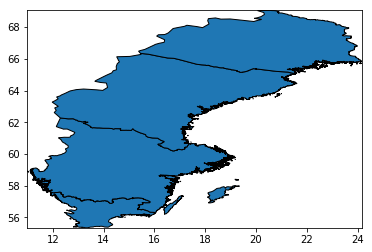

In [5]:
fig, ax = plt.subplots()  # Create figure and axis

# Set canvas limits to bounds of the whole shapefile
ax.set_xlim(x1, x2)
ax.set_ylim(y1, y2)

# Add each shape as a polygon
for s in shapes:
    ax.add_patch(PolygonPatch(s))

### Reanalysis runoff data
We used MERRA-2 data as source for runoff values. First, we need to get total land area in each computation grid cell. We use data collection [M2C0NXASM](https://doi.org/10.5067/ME5QX6Q5IGGU) for the fraction of land in each cell. Local function `cell_area` is used to calculate the area of each cell on earth’s surface.

In [6]:
with xa.open_dataset(os.path.join(MERRA2_data_dir, 'MERRA2_101.const_2d_asm_Nx.00000000.nc4')) as ds:
    frland = ds['FRLAND'].isel(time=0, drop=True)
    area = xa.apply_ufunc(cell_area, ds.lat, ds.lon, XSIZE, YSIZE) * frland


We use data collection [M2T1NXLND](https://doi.org/10.5067/RKPHT8KC1Y1T) for overland runoff (kg m<sup>–2</sup> s<sup>–1</sup>). Since the values are mass flow per unit area, we multiply with the cell area first.

In [7]:
with xa.open_mfdataset(os.path.join(MERRA2_data_dir, 
                                    'MERRA-2.tavg1_2d_lnd_Nx.2017*.SUB.nc4')) as ds:
    runoff = ds['runoff'] * area  # Multiply with cell areas
    
    # Add new dimension with zone information
    runoff_new = add_zone_dim(runoff, nodes, shapes, crs=PROJ4, xsize=XSIZE, ysize=YSIZE, dim='node')
    
    # Calculate mean over latitude and longitude (preserving other dimensions: time and node) 
    # and convert to a pandas time series.
    runoff_mean = runoff_new.mean(['lat', 'lon']).compute().to_pandas().T

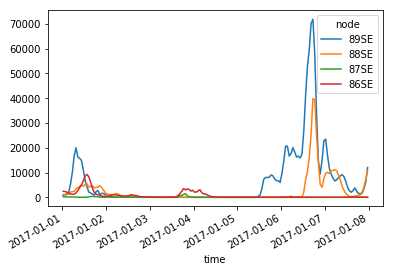

In [8]:
runoff_mean.plot()

Calculate the share of each node at each hour. Fill gaps using linear interpolation.

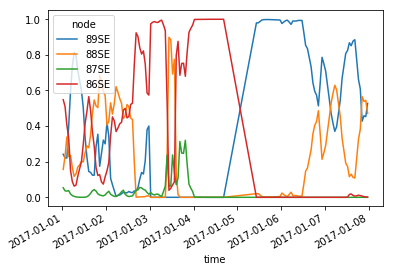

In [9]:
runoff_share = runoff_mean.div(runoff_mean.sum(1), axis=0).interpolate()

runoff_share.plot()

### Hydropower inflow energy

Load weekly inflow data at national level. (This data cannot be shared, thus not included in online version.)

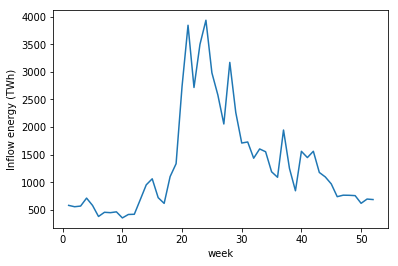

In [10]:
weekly_inflow = pd.read_excel(r"C:\DATA\Misc. data\SE_hydropower_inflow_1950-2017.xlsx", sheet_name='data', 
                       skiprows=[0], index_col=0)[2017]
fig, ax = plt.subplots()
ax.set_ylabel("Inflow energy (TWh)")
weekly_inflow.plot(ax=ax)

Calculate the start hour of every week and construct a new index.

In [11]:
idx = runoff_mean.index[0] + pd.TimedeltaIndex((weekly_inflow.index - 1) * 168, unit='h')
idx.name = 'timestamp'

Create new time series with hourly time stamps, in MWh/h. Reindex to the same index as previous runoff shares and fill gaps using linear interpolation.

In [12]:
hourly_inflow = pd.Series(weekly_inflow.values / 168 * 1e3, 
                          index=idx).reindex(runoff_share.index).interpolate()
hourly_inflow.head()

time
2017-01-01 00:30:00.000006    3485.119048
2017-01-01 01:30:00.000000    3485.119048
2017-01-01 02:30:00.000000    3485.119048
2017-01-01 03:30:00.000006    3485.119048
2017-01-01 04:30:00.000000    3485.119048
dtype: float64

Calculate nodal inflows by multiplying the national values by runoff shares in each node.

In [13]:
nodal_inflow = runoff_share.mul(hourly_inflow, axis='index')

### Post-processing
Write input to Backbone energy system model. First, create a data frame with appropriate dimensions.

In [15]:
ts_influx = pd.DataFrame(nodal_inflow.values, 
                         index=pd.MultiIndex.from_product([['f00'], 
                                                           [f't{t + 1:06d}' for t 
                                                            in range(len(nodal_inflow.index))]
                                                          ]),
                         columns=pd.MultiIndex.from_product([['hydro'], 
                                                             [f'{node}_Reservoir' 
                                                              for node in nodal_inflow.columns]
                                                            ])
                        )
ts_influx.index.names = ['f', 't']
ts_influx.columns.names = ['grid', 'node']
ts_influx.head()

grid                 hydro                                             
node        89SE_Reservoir 88SE_Reservoir 87SE_Reservoir 86SE_Reservoir
f   t                                                                  
f00 t000001     841.837550     546.356494     186.788545    1910.136459
    t000002     773.290980     807.797990     126.487225    1777.542852
    t000003     768.743827    1182.015486     120.877106    1413.482629
    t000004    1398.579259     796.637286     130.891076    1159.011427
    t000005    2076.035975     820.646261      64.821345     523.615466

Write to a gdx file

In [ ]:
from gdx2py import GdxFile

with GdxFile('hydro_inflow-SE.gdx', 'w') as gdx:
    gdx['ts_influx'] = ts_influx.stack([0,1]).reorder_levels([2,3,0,1]).sort_index()